<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gaussian-mixture" data-toc-modified-id="Gaussian-mixture-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gaussian mixture</a></span></li><li><span><a href="#Data-generation-and-plot" data-toc-modified-id="Data-generation-and-plot-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data generation and plot</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing</a></span></li></ul></div>

# Gaussian mixture

This is the implementation of our full gaussian mixture algorithm.
The best lecture I found is http://people.csail.mit.edu/dsontag/courses/ml12/slides/lecture21.pdf .
In guassian mixture model, we assume the all examples are generated in probability of $n$ components

$$
\sum_k^n \frac{p_k}{2\pi\sqrt{|\sigma_k|}}e^{-(X-\mu_k)^T\sigma^{-1}_k(X-\mu_k)}
$$
where 
$p_k$ is a probability of $k$ components. And we have $\sum_k p_k = 1$.
The $\sigma_k$ is $n_f\times n_f$ semi-defined matrix. where $n_f$ is the number of features, or the dimension of an example. The $|\sigma_k|$ is the determine of $\sigma_k$.


The optimization problems is solved EM algorithm.

In [7]:
import numpy as np
class GaussianMixture:
    def __init__(self, n_components=1,max_iter=100,random_state=42):
        self.n_components=n_components
        self.max_iter=max_iter
        self.random_state=np.random.RandomState(random_state)
        
        
    def cal_com_weights(self, X, ps, mus, sigmas):
        ncom= ps.shape[-1]
        nfeature = X.shape[-1]
        ndata = X.shape[-2]
        
        # [ndata, ncom, nfeature]
        xd = X[:,np.newaxis,:] - mus
        assert xd.shape == (ndata, ncom, nfeature)
        # [ncom, nfeature, nfeature]
        invsigmas = np.linalg.inv(sigmas)
        assert invsigmas.shape == (ncom, nfeature, nfeature)

        # [ndata, ncom, nfeature]
        invxd = np.sum(invsigmas*xd[:,:,np.newaxis,:], axis=-1)            
        assert invxd.shape == (ndata, ncom, nfeature), invxd.shape

        det = np.linalg.det(sigmas)

        # [ndata, ncom]
        g = ps/np.sqrt(det)*np.exp(-np.sum(xd*invxd, axis=-1))
        assert g.shape == (ndata, ncom), g.shape

        # [ndata]
        n = np.sum(g, axis=-1)
        assert n.shape == (ndata,), n.shape
        # [ndata, ncom]
        P = g / n[:,np.newaxis]
        #print("P", P)
        return P
        
    def fit(self,X):
        # [ndata, nfeature]
        # X
        assert X.ndim >= 2        
        means=np.mean(X, axis=-2)
        stds = np.std(X, axis=-2)
        n_components = self.n_components
        ncom= n_components
        nfeature = X.shape[-1]
        ndata = X.shape[-2]
        
        # [ncom, nfeature]
        mus = means + stds*self.random_state.randn(n_components, means.shape[-1])        
        #print(mus)
        # [ncom]
        ps = np.ones(n_components)/n_components        
        # [ncom, nfeature, nfeature]
        sigmas = np.tile(np.diag(stds), (n_components, 1, 1))
        #print(sigmas)
        
        
        # the best lecture I found http://people.csail.mit.edu/dsontag/courses/ml12/slides/lecture21.pdf        
        for n_iter in range(self.max_iter):
            
            # [ndata, ncom, nfeature]
            xd = X[:,np.newaxis,:] - mus
            
            # [ndata, ncom]
            P = self.cal_com_weights(X, ps, mus, sigmas)
            # [ncom]
            N = np.sum(P, axis=-2)
                       
            ps = N/X.shape[-2]            
            #print("ps", ps)
            
            # [ncom, nfeature]
            mus = np.einsum("ij,ik->jk", P, X) / N[:,np.newaxis]
            #print(mus)
                        
            
            #[ndata, ncom, nfeature, nfeature]
            xcov = np.einsum("ijk,ijl->ijkl", xd, xd)
            assert xcov.shape == (ndata, ncom, nfeature, nfeature), xcov.shape
            sigmas = np.einsum("ij,ijkl->jkl", P, xcov) / N[:,np.newaxis, np.newaxis]
            #print(sigmas)
            
        self.weights_ = ps
        self.means_ = mus
        self.covariances_ = sigmas
        
    def predict(self, X):
        # [ndata, ncom]
        P = self.cal_com_weights(X, self.weights_, self.means_, self.covariances_)
        argmax = np.argmax(P, axis=-1)
        return argmax
        
        
    
    

# Data generation and plot

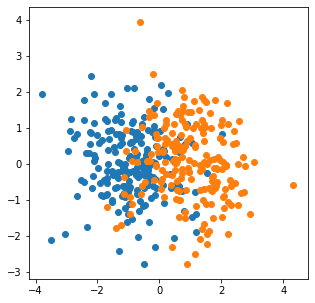

In [62]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_data(center, transform=None, n=200, random_state=1):
    center=np.array(center)
    rnd = np.random.RandomState(random_state)

    if transform is None:
        transform = [np.diag(np.ones(2))]*len(center)
    transform=np.array(transform)
                
    if isinstance(n, int):
        n=np.full(len(center), n)

    Xs=[]
    ys=[]
    for i in range(len(center)):
        c = center[i]
        tr = transform[i]
        n_ = n[i]
        
        Xs.append((rnd.randn(n_, 2) + c).dot(tr))
        ys.append(np.full(n_, i))

    
    X = np.vstack(Xs)
    y = np.hstack(ys)
    pert = np.random.permutation(X.shape[0])
    X = X[pert]
    y = y[pert]

    return X, y


def plot_data(X, y):
    plt.figure(figsize=(5, 5))
    nlabels = int(np.amax(y) + 1)
    for i in range(nlabels):
        plt.scatter(X[y == i, 0], X[y == i, 1])

    plt.show()

    

X,y=gen_data([[-1,0],[+1,0]])
plot_data(X, y)
plt.show()

From here https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html or https://gist.github.com/CarstenSchelp/b992645537660bda692f218b562d0712
, we copy and edit a function to plot an ellipse with given center and covariance matrix. And the reason is explained in https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html .

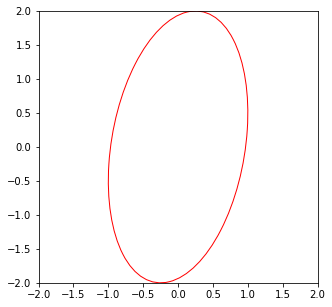

In [147]:
# copy and edit from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(center, cov, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """

    cov=np.array(cov)
    center=np.array(center)
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = center[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = center[1]
        
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)   
    
    ellipse.set_transform(transf + ax.transData)    
        
    return ax.add_patch(ellipse)


fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim((-2,2))
ax.set_ylim((-2,2))
confidence_ellipse([0,0], cov=[[1,0.5],[0.5,4]], ax=ax, edgecolor='red')
plt.show()

# Testing

We generate a dataset in four categories. In each category, the examples are distributed in gaussian distribution. Then we use our `GaussianMixture` class to classify all examples into four categories without seeing the actual labels.

means[0]
 [-5.96994766  0.00899069]
covariances[0]
 [[ 4.02739832 -0.05811803]
 [-0.05811803  0.98653148]]
weights[0]
 0.5001308578100963
means[1]
 [ 3.01976639 -0.01771308]
covariances[1]
 [[ 1.00810169 -0.02733906]
 [-0.02733906  0.98151544]]
weights[1]
 0.49986914218990375


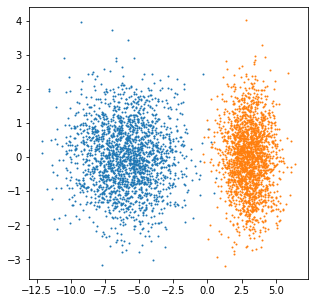

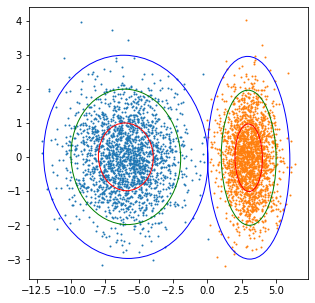

In [156]:
def test_GaussianMixture(center, transform=None):
    X,y=gen_data(center, transform=transform, n=2000)
    fig, ax = plt.subplots(figsize=(5, 5))
    nlabels = int(np.amax(y) + 1)
    for i in range(nlabels):
        ax.scatter(X[y == i, 0], X[y == i, 1],s=1)
    
    
    
    gm=GaussianMixture(n_components=len(center), max_iter=100)
    gm.fit(X)
    y=gm.predict(X)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    nlabels = int(np.amax(y) + 1)
    for i in range(nlabels):
        ax.scatter(X[y == i, 0], X[y == i, 1],s=1)
        confidence_ellipse(gm.means_[i], gm.covariances_[i], ax=ax, edgecolor='red', n_std=1)
        confidence_ellipse(gm.means_[i], gm.covariances_[i], ax=ax, edgecolor='green', n_std=2)
        confidence_ellipse(gm.means_[i], gm.covariances_[i], ax=ax, edgecolor='blue', n_std=3)
    for i in range(nlabels):
        print("means[%d]\n"%i, gm.means_[i])
        print("covariances[%d]\n"%i, gm.covariances_[i])
        print("weights[%d]\n"%i, gm.weights_[i])

test_GaussianMixture([[-3,0],[3,0]],
                    transform=[[[2,0],[0,1]], [[1,0],[0,1]]])